In [10]:
import warnings; warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import itertools

In [11]:
# 2. Load Dataset

df = pd.read_csv(r"C:\Users\LENOVO\Stock price analysis project\AAPL.csv", parse_dates=["Date"], index_col="Date").sort_index()

y = df["Adj Close"].asfreq("B")     # business-day frequency
y = y.ffill()                       # forward fill missing values
returns = df["Adj Close"].pct_change().dropna()
print("Data Loaded:")
print(y.head(), y.tail(), sep="\n\n")

Data Loaded:
Date
2012-01-03    50.765709
2012-01-04    51.038536
2012-01-05    51.605175
2012-01-06    52.144630
2012-01-09    52.061932
Freq: B, Name: Adj Close, dtype: float64

Date
2019-12-24    282.322266
2019-12-25    282.322266
2019-12-26    287.923645
2019-12-27    287.814392
2019-12-30    289.522614
Freq: B, Name: Adj Close, dtype: float64


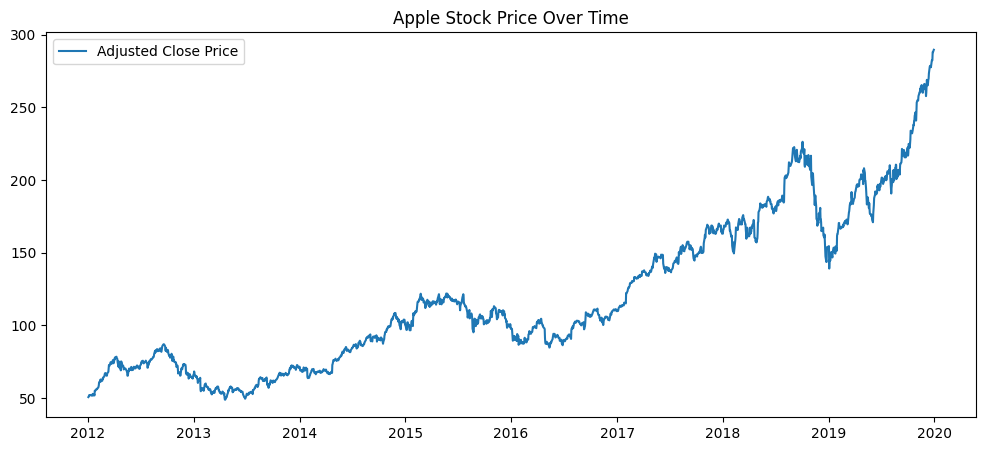

In [12]:
# 3. Exploratory Data Analysis (EDA)

plt.figure(figsize=(12,5))
plt.plot(y, label="Adjusted Close Price")
plt.title("Apple Stock Price Over Time")
plt.legend()
plt.show()

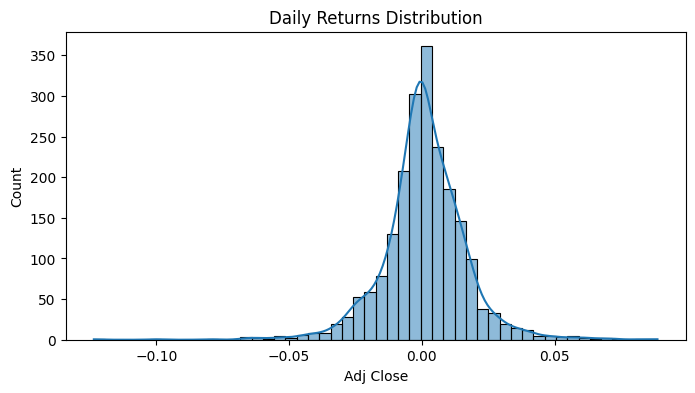

In [13]:
# Distribution of returns
returns = y.pct_change().dropna()
plt.figure(figsize=(8,4))
sns.histplot(returns, bins=50, kde=True)
plt.title("Daily Returns Distribution")
plt.show()

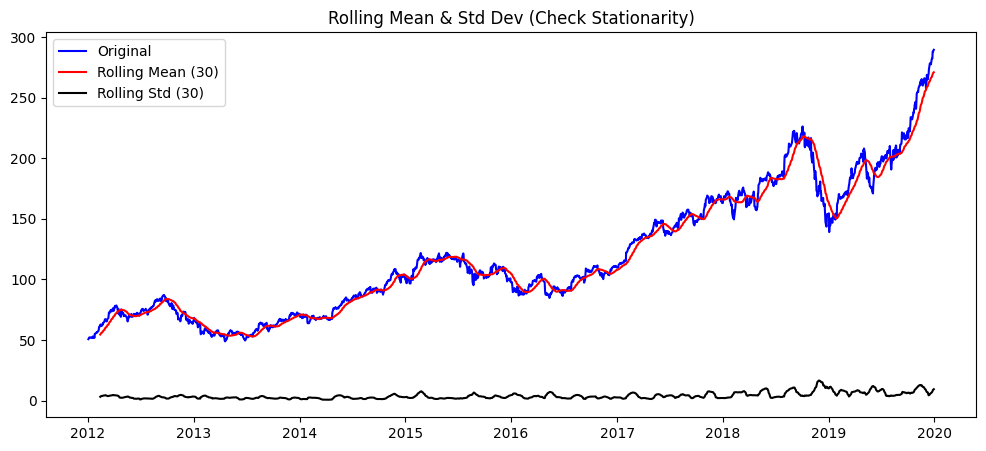

In [14]:
# 4. Rolling Statistics (Stationarity Visual Check)

rol_mean = y.rolling(30).mean()
rol_std = y.rolling(30).std()

plt.figure(figsize=(12,5))
plt.plot(y, color="blue", label="Original")
plt.plot(rol_mean, color="red", label="Rolling Mean (30)")
plt.plot(rol_std, color="black", label="Rolling Std (30)")
plt.title("Rolling Mean & Std Dev (Check Stationarity)")
plt.legend()
plt.show()

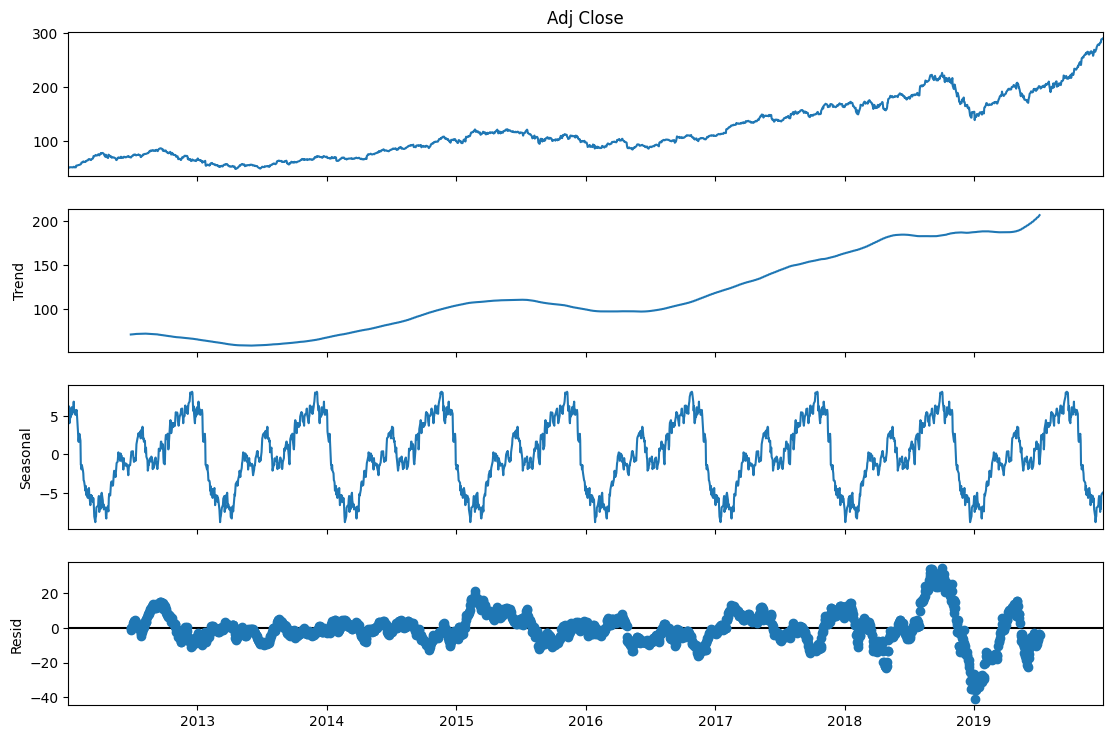

In [15]:
# 6. Decomposition

decomp = seasonal_decompose(y, model="additive", period=252) # ~1 year
fig = decomp.plot()
fig.set_size_inches(12,8)


plt.show()

In [16]:
# 5. Stationarity Tests (ADF + KPSS)
def adf_test(series, title=""):
    result = adfuller(series, autolag="AIC")
    print(f"ADF Test for {title}")
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("=> Stationary" if result[1] < 0.05 else "=> Non-Stationary")
    print("-"*50)

def kpss_test(series, title=""):
    statistic, p_value, _, _ = kpss(series, regression="c")
    print(f"KPSS Test for {title}")
    print("KPSS Statistic:", statistic)
    print("p-value:", p_value)
    print("=> Stationary" if p_value > 0.05 else "=> Non-Stationary")
    print("-"*50)

adf_test(y, "Adj Close Price")
kpss_test(y, "Adj Close Price")

ADF Test for Adj Close Price
ADF Statistic: 1.1980445709034273
p-value: 0.995972345115903
=> Non-Stationary
--------------------------------------------------
KPSS Test for Adj Close Price
KPSS Statistic: 6.301791487592512
p-value: 0.01
=> Non-Stationary
--------------------------------------------------


ADF Test for Daily Returns
ADF Statistic: -32.97710889126504
p-value: 0.0
=> Stationary
--------------------------------------------------
KPSS Test for Daily Returns
KPSS Statistic: 0.08247020536342647
p-value: 0.1
=> Stationary
--------------------------------------------------


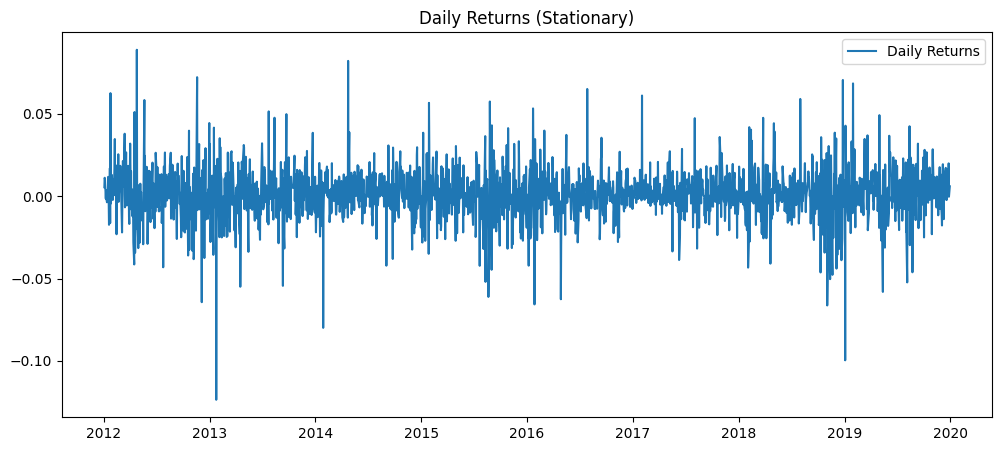

In [17]:
# 5. Convert to returns (stationary series)


returns = y.pct_change().dropna()
adf_test(returns, "Daily Returns")
kpss_test(returns, "Daily Returns")

plt.figure(figsize=(12,5))
plt.plot(returns, label="Daily Returns")
plt.title("Daily Returns (Stationary)")
plt.legend()
plt.show()


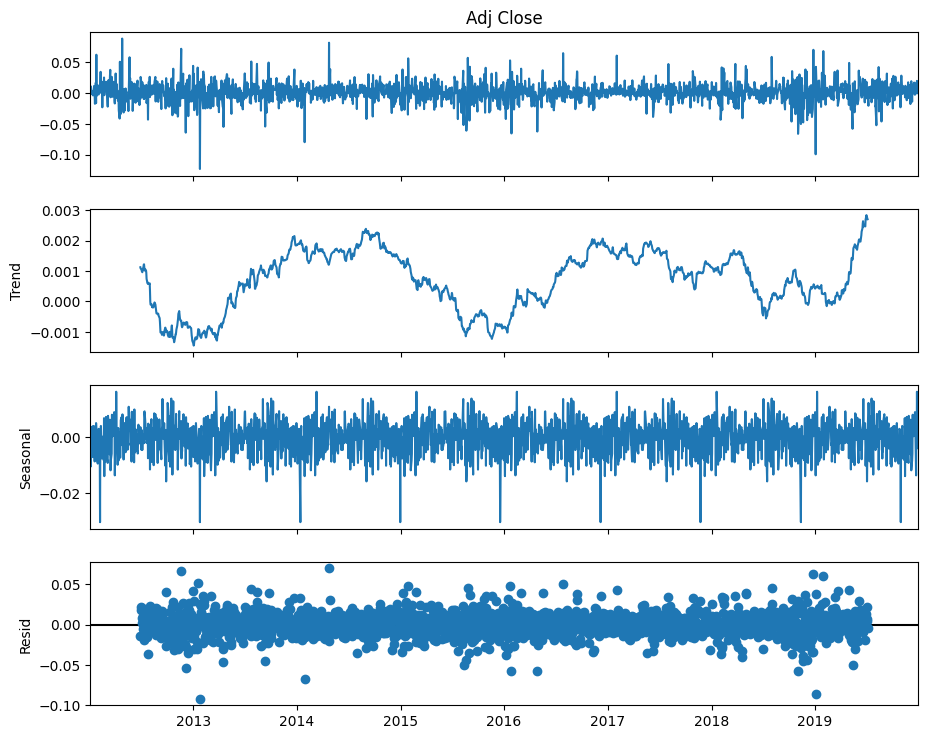

In [18]:
# Decomposition on returns (stationary)
decomp = seasonal_decompose(returns, model="additive", period=252)  # period ~ 1 month

# Plot decomposition
fig = decomp.plot()
fig.set_size_inches(10,8)
plt.show()

In [21]:
# 6. Train/Test split

n = len(returns)
test_size = int(n*0.2)
train, test = returns.iloc[:-test_size], returns.iloc[-test_size:]

print("Train size:", len(train))
print("Test size:", len(test))


Train size: 1668
Test size: 416


In [32]:
# 7. ACF & PACF Plots

#fig, ax = plt.subplots(1,2, figsize=(14,5))
#plot_acf(diff_series, lags=40, ax=ax[0])
#plot_pacf(diff_series, lags=40, ax=ax[1], method="ywm")
#ax[0].set_title("ACF (use for q)")
#ax[1].set_title("PACF (use for p)")
#plt.show()

In [23]:
from pmdarima import auto_arima

In [24]:
#!pip install pmdarima

In [25]:
# 7. Model selection using Auto ARIMA

stepwise_fit = auto_arima(train, start_p=0, start_q=0,
                          max_p=5, max_q=5, d=0,
                          seasonal=False, trace=True,
                          error_action="ignore", suppress_warnings=True)

print(stepwise_fit.summary())


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-9173.288, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-9172.568, Time=0.36 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-9172.600, Time=0.56 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-9170.630, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-9176.812, Time=0.49 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-9175.813, Time=0.38 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-9175.844, Time=0.46 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-9173.917, Time=0.63 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 3.621 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1668
Model:                        SARIMAX   Log Likelihood                4590.406
Date:                Mon, 01 Sep 2025   AIC                          -9176.812
Time:                       

In [26]:
# 8. Fit final ARIMA model on train set

model = ARIMA(train, order=stepwise_fit.order)
fit = model.fit()
print(fit.summary())


                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 1668
Model:                          ARIMA   Log Likelihood                4590.406
Date:                Mon, 01 Sep 2025   AIC                          -9176.812
Time:                        18:05:05   BIC                          -9165.973
Sample:                    01-04-2012   HQIC                         -9172.795
                         - 05-25-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.335      0.020       0.000       0.002
sigma2         0.0002   4.22e-06     56.573      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   1.00   Jarque-

In [27]:
# 9. Forecast returns on test set

fc = fit.get_forecast(steps=len(test))
fc_returns = fc.predicted_mean

# Reconstruct prices from returns forecast
last_train_price = y.iloc[: -test_size].iloc[-1]
forecasted_prices = [last_train_price]
for r in fc_returns:
    forecasted_prices.append(forecasted_prices[-1] * (1 + r))

forecasted_prices = pd.Series(forecasted_prices[1:], index=test.index)


RMSE: 33.02473338539029
MAE : 27.744441237183512


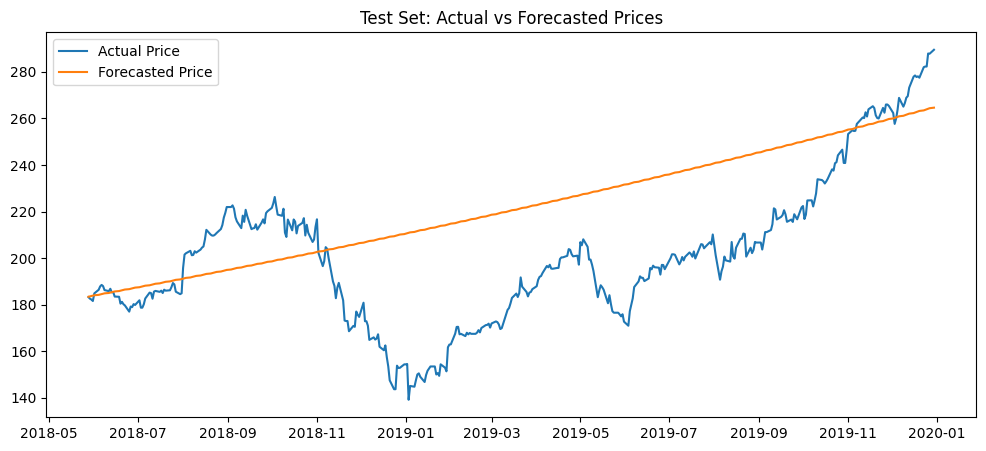

In [29]:
# 10. Evaluate model

rmse = np.sqrt(mean_squared_error(y.iloc[-test_size:], forecasted_prices))
mae = mean_absolute_error(y.iloc[-test_size:], forecasted_prices)


print("RMSE:", rmse)
print("MAE :", mae)

plt.figure(figsize=(12,5))
plt.plot(y.iloc[-test_size:], label="Actual Price")
plt.plot(forecasted_prices, label="Forecasted Price")
plt.title("Test Set: Actual vs Forecasted Prices")
plt.legend()
plt.show()

In [30]:
# 11. Final Model & 30-Day Forecast

final_model = ARIMA(returns, order=stepwise_fit.order)
final_fit = final_model.fit()

n_days = 30
future_returns, conf_int = stepwise_fit.predict(n_periods=n_days, return_conf_int=True)

last_price = y.iloc[-1]
future_prices = [last_price]
for r in future_returns:
    future_prices.append(future_prices[-1] * (1 + r))

future_prices = pd.Series(future_prices[1:], 
                          index=pd.date_range(start=y.index[-1]+pd.Timedelta(days=1),
                                              periods=n_days, freq="B"))


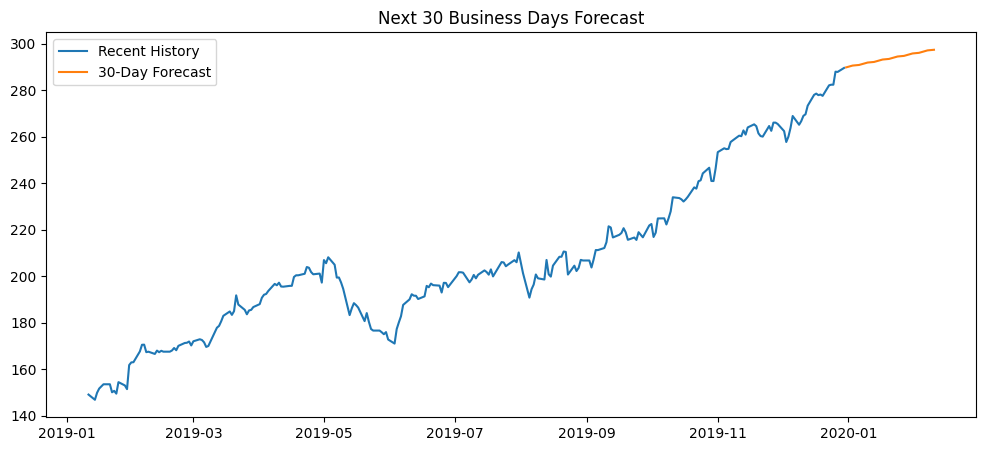


Forecasted Prices for next 30 days:
2019-12-31    289.780040
2020-01-01    290.037694
2020-01-02    290.295578
2020-01-03    290.553691
2020-01-06    290.812034
2020-01-07    291.070606
2020-01-08    291.329408
2020-01-09    291.588441
2020-01-10    291.847703
2020-01-13    292.107196
2020-01-14    292.366920
2020-01-15    292.626875
2020-01-16    292.887061
2020-01-17    293.147478
2020-01-20    293.408127
2020-01-21    293.669008
2020-01-22    293.930120
2020-01-23    294.191465
2020-01-24    294.453042
2020-01-27    294.714851
2020-01-28    294.976894
2020-01-29    295.239169
2020-01-30    295.501678
2020-01-31    295.764420
2020-02-03    296.027395
2020-02-04    296.290605
2020-02-05    296.554048
2020-02-06    296.817726
2020-02-07    297.081638
2020-02-10    297.345785
Freq: B, dtype: float64


In [31]:
# Plot forecast
plt.figure(figsize=(12,5))
plt.plot(y.index[-252:], y[-252:], label="Recent History")
plt.plot(future_prices.index, future_prices.values, label="30-Day Forecast")
plt.title("Next 30 Business Days Forecast")
plt.legend()
plt.show()

print("\nForecasted Prices for next 30 days:")
print(future_prices)


In [ ]:
# 12. Interactive Prediction (User input)

day = int(input("Enter which day ahead you want to predict (1-30): "))
if 1 <= day <= 30:
    print(f"\nPredicted price for Day {day}: {future_prices.iloc[day-1]:.2f}")
else:
    print(" Please enter a number between 1 and 30")

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd

# Let's decompose your stationary series (returns)
decomp = seasonal_decompose(returns, model="additive", period=30)

# Create dataframe with all components
decomp_df = pd.DataFrame({
    "date": returns.index,
    "observed": decomp.observed.values,
    "trend": decomp.trend.values,
    "seasonal": decomp.seasonal.values,
    "resid": decomp.resid.values
})

# Save to CSV
decomp_df.to_csv("decomposition.csv", index=False)

print(" Decomposition data saved as decomposition.csv")


In [ ]:
decomp_df = decomp_df.fillna(method="bfill").fillna(method="ffill")


In [ ]:
# Save forecast(future prise) to CSV
future_prices.to_csv("future_prices.csv", index=False)
print(" Forecasted prices saved successfully!")

In [ ]:
#model saving in binary mode
import pickle

In [ ]:
with open("model_pickle","wb")as f:
    pickle.dump(model,f)

In [ ]:
with open("model_pickle","rb")as f:
    mp=pickle.load(f)